# Imports and functions

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import copy as cp
from time import time
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from scipy.stats import norm
import math
import argparse
from argparse import ArgumentParser
import json

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import autograd
import torch.cuda
from torch.func import stack_module_state, vmap, functional_call

rng = np.random.default_rng()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

try :
  print(torch.cuda.get_device_name(0))
except :
  print("No GPU is available.")

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

cuda:0
Tesla T4


In [2]:
!git clone https://github.com/anthony-frion/AIKAE

from AIKAE.models import KoopmanAE, IKAE, IKAE_zp, AIKAE, NICE, RealNVP

Cloning into 'AIKAE'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 55), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (147/147), 18.30 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def mse_loss(x, x_hat):
  total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
  return total_prediction_loss

def relative_mse_loss(x, x_hat):
  total_prediction_loss = torch.sum((x-x_hat)**2/x**2)/(x.size()[0])
  return total_prediction_loss

def kl_div(mu, var, scale=1): #KL divergence with a standard normal distribution
  #return torch.sum((torch.exp(logvar) **2 + mu **2) - logvar - 1)
  return torch.sum((var + mu **2) / (2 * scale) + np.log(np.sqrt(scale)) - torch.log(torch.sqrt(var)) - 1/2)

def positive_identity(x):
  y = x.clone()
  y[y>0] = y[y>0] + 1
  y[y<0] = torch.exp(y[y<0])

In [4]:
import numpy as np


def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    d += 1e-12
    return 0.01*(u / d).mean(-1)


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse = RSE(pred, true)
    corr = CORR(pred, true)

    return mae, mse, rmse, mape, mspe, rse, corr

## Data factory

In [5]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset


class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [6]:
import os
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')


class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h', train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_ETT_minute(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTm1.csv',
                 target='OT', scale=True, timeenc=0, freq='t', train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 * 4 - self.seq_len, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - self.seq_len]
        border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Custom(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h', train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq
        self.train_only = train_only

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        if self.features == 'S':
            cols.remove(self.target)
        cols.remove('date')
        # print(cols)
        num_train = int(len(df_raw) * (0.7 if not self.train_only else 1))
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            df_raw = df_raw[['date'] + cols]
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_raw = df_raw[['date'] + cols + [self.target]]
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            # print(self.scaler.mean_)
            # exit()
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Pred(Dataset):
    def __init__(self, root_path, flag='pred', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, inverse=False, timeenc=0, freq='15min', cols=None, train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['pred']

        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        if self.cols:
            cols = self.cols.copy()
        else:
            cols = list(df_raw.columns)
            self.cols = cols.copy()
            cols.remove('date')
        if self.features == 'S':
            cols.remove(self.target)
        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            df_raw = df_raw[['date'] + cols]
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_raw = df_raw[['date'] + cols + [self.target]]
            df_data = df_raw[[self.target]]

        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len + 1, freq=self.freq)

        df_stamp = pd.DataFrame(columns=['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        self.future_dates = list(pred_dates[1:])
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = self.data_x[r_begin:r_begin + self.label_len]
        else:
            seq_y = self.data_y[r_begin:r_begin + self.label_len]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

## Data loader

In [7]:
from torch.utils.data import DataLoader

data_dict = {
    'ETTh1': Dataset_ETT_hour,
    'ETTh2': Dataset_ETT_hour,
    'ETTm1': Dataset_ETT_minute,
    'ETTm2': Dataset_ETT_minute,
    'custom': Dataset_Custom,
}

class DatasetWrapper(Dataset):
    def __init__(self, original_dataset, offset):
        self.original_dataset = original_dataset
        self.offset = offset

    def __len__(self):
        # Return the number of samples excluding the first offset
        return len(self.original_dataset) - self.offset

    def __getitem__(self, idx):
        # Offset index by offset to skip the first offset samples
        return self.original_dataset[idx + self.offset]

def data_provider(args, flag):
    Data = data_dict[args.data]
    timeenc = 0 if args.embed != 'timeF' else 1
    train_only = args.train_only

    if flag == 'test':
        shuffle_flag = False
        drop_last = False
        batch_size = args.batch_size
        freq = args.freq
    elif flag == 'pred':
        shuffle_flag = False
        drop_last = False
        batch_size = 1
        freq = args.freq
        Data = Dataset_Pred
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        train_only=train_only
    )
    if args.seq_len < 48:
      data_set = DatasetWrapper(data_set, 48 - args.seq_len)

    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,#[max(0,48-args.seq_len):],
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader

In [8]:
a = np.random.randn(1000)
print(a.shape)
print(a[-42:].shape)

(1000,)
(42,)


# Data loading

Here, you should manually choose which dataset to use, as well as the number of predicted time steps. Most of the datasets are directly available in the repository. The Traffic and Electricity datasets are too big to directly fit there, but you can download them from e.g. https://drive.google.com/drive/folders/1ZOYpTUa82_jCcxIdTmyr0LXQfvaM9vIy

In [9]:
dataset = "ETTh1" # Choose a dataset from this list
dataset = "ETTh2"
#dataset = "ETTm1"
#dataset = "ETTm2"
#dataset = "electricity"
#dataset = "traffic"
#dataset = "weather"
#dataset = "exchange_rate"

pred_len = 96 # Choose between the 4 tested prediction lengths, or define your own
#pred_len = 192
#pred_len = 336
#pred_len = 720

torch.manual_seed(42)
np.random.seed(42)
parser = ArgumentParser()
args = parser.parse_known_args()[0]
args_path = f'AIKAE/datasets/{dataset}.txt' # Make sure that this is the right path
with open(args_path, 'r') as f:
    args.__dict__ = json.load(f)
#print(args)
args.root_path = 'AIKAE/datasets/' # Make sure this is the path to the csv files
args.data_path = dataset + ".csv"
args.seq_len = 96
args.pred_len = pred_len
args.batch_size = 4 if "ETT" in dataset else 32

print(f"Preparing data for {pred_len}-step predictions on the {dataset} dataset.")
torch.manual_seed(42)
np.random.seed(42)
data_set, data_loader = data_provider(args, flag='train')
validation_set, validation_loader = data_provider(args, flag='val')
test_set, test_loader = data_provider(args, flag='test')

Preparing data for 96-step predictions on the ETTh2 dataset.
train 8449
val 2785
test 2785


0
torch.Size([4, 96, 7]) torch.Size([4, 144, 7]) torch.Size([4, 96, 4]) torch.Size([4, 144, 4])
tensor(-1.4623, dtype=torch.float64) tensor(1.4324, dtype=torch.float64)


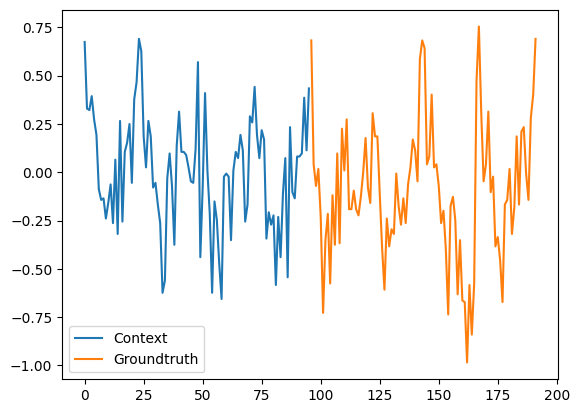

In [10]:
# Visualise some sampled data from the dataset
print(data_set)
print(data_loader)
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
  print(i)
  print(batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape)
  print(torch.min(batch_x), torch.max(batch_x))
  ind = rd.randint(0,batch_x.shape[0]-1)
  ind_2 = rd.randint(0,batch_x.shape[2]-1)
  plt.plot(batch_x[ind,:,ind_2], label='Context')
  plt.plot([batch_x.shape[1]+k for k in range(batch_y.shape[1]-48)], batch_y[ind,48:,ind_2], label='Groundtruth')
  plt.legend()
  break

# Training

In [11]:
#model_name = "IKAE" # Choose between the two models
model_name = "AIKAE"

input_dim = batch_x.shape[1]
hidden_dim = 256
n_layers_encoder = 4
augmentation_dims = [256,128,32]

torch.manual_seed(42)
np.random.seed(42)
if model_name == "IKAE":
  model = IKAE.IKAE(input_dim, hidden_dim, n_layers_encoder=n_layers_encoder,
               positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
elif model_name == "AIKAE":
  model = AIKAE.AIKAE(input_dim, hidden_dim, n_layers_encoder=n_layers_encoder, augmentation_dims=augmentation_dims,
                positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
print(count_parameters(model))
print(model)

RevIN = 1

161376
AIKAE(
  (positive_nonlin): Softplus(beta=1.0, threshold=20.0)
  (invertible_encoder): stacked_NICE(
    (bijectors): ModuleList(
      (0-3): 4 x NICE(
        (net): Sequential(
          (0): Linear(in_features=48, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=256, out_features=48, bias=True)
        )
      )
    )
  )
  (augmentation_encoder): ModuleList(
    (0): Linear(in_features=96, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
)


In [12]:
epochs = 100
opt = model.configure_optimizers(lr=1e-3)
max_patience = 20
patience = 0

if RevIN:
  gammas = torch.ones(batch_x.shape[2]).to(device).requires_grad_()
  betas = torch.zeros(batch_x.shape[2]).to(device).requires_grad_()
  opt.add_param_group({"params": [gammas, betas]})
  eps = 1e-6

best_validation_loss = 1e15

for epoch in range(epochs):
  patience += 1
  if patience > max_patience:
    print("Early stopping due to exceeded patience.")
    break
  model.train()
  epoch_loss = 0
  for batch, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
    opt.zero_grad()
    batch_x = batch_x
    batch_y = batch_y
    x0 = batch_x.float().to(device)
    if RevIN:
      mus = torch.mean(x0, dim=(0,1))
      x0 -= mus
      sigmas = torch.std(x0, dim=(0,1), correction=0)
      x0 /= (sigmas + eps)
      x0 = gammas * x0 + betas
    x0 = x0.permute((0,2,1)).flatten(0,1)
    gt = batch_y.float().to(device)[:,-args.pred_len:]
    gt = gt.permute((0,2,1)).flatten(0,1)
    batch_size = x0.shape[0]
    phis_0 = model.encode(x0)
    phis_pred = [phis_0]
    for k in range(math.ceil(args.pred_len / args.seq_len)):
      phis_pred.append(model.one_step_ahead(phis_pred[-1]))
    phis_pred = torch.stack(phis_pred[1:], dim=1).flatten(0,1)
    loss = 0
    # Prediction loss
    predictions = model.decode(phis_pred)
    if RevIN:
      predictions = predictions.reshape(batch_x.shape[0], batch_x.shape[2],
                                        args.seq_len * math.ceil(args.pred_len / args.seq_len))[:,:,:args.pred_len].permute((0,2,1))
      predictions = (predictions - betas) / gammas
      predictions = predictions * (sigmas + eps) + mus
      predictions = predictions.permute((0,2,1)).flatten(0,1)
    prediction_loss = mse_loss(predictions, gt)
    loss += prediction_loss
    loss.backward()
    opt.step()
    epoch_loss += loss.detach().item()
    #break
  epoch_loss /= (batch+1)
  #scheduler.step()
  model.eval()
  validation_loss = 0
  for batch, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(validation_loader):
    opt.zero_grad()
    batch_x = batch_x
    batch_y = batch_y
    x0 = batch_x.float().to(device)
    if RevIN:
      mus = torch.mean(x0, dim=(0,1))
      x0 -= mus
      sigmas = torch.std(x0, dim=(0,1), correction=0)
      x0 /= (sigmas + eps)
      x0 = gammas * x0 + betas
    x0 = x0.permute((0,2,1)).flatten(0,1)
    gt = batch_y.float().to(device)[:,-args.pred_len:]
    gt = gt.permute((0,2,1)).flatten(0,1)
    phis_0 = model.encode(x0)
    phis_pred = [phis_0]
    for k in range(math.ceil(args.pred_len / args.seq_len)):
      phis_pred.append(model.one_step_ahead(phis_pred[-1]))
    phis_pred = torch.stack(phis_pred[1:], dim=1).flatten(0,1)
    loss = 0
    predictions = model.decode(phis_pred)
    if RevIN:
      predictions = predictions.reshape(batch_x.shape[0], batch_x.shape[2],
                                        args.seq_len * math.ceil(args.pred_len / args.seq_len))[:,:,:args.pred_len].permute((0,2,1))
      predictions = (predictions - betas) / gammas
      predictions = predictions * (sigmas + eps) + mus
      predictions = predictions.permute((0,2,1)).flatten(0,1)
    prediction_loss = mse_loss(predictions, gt)
    loss += prediction_loss
    validation_loss += loss.detach().item()
  validation_loss /= (batch+1)
  print(f"Epoch {epoch}: training loss {epoch_loss}, validation loss {validation_loss}")
  if validation_loss < best_validation_loss:
    patience = 0
    best_validation_loss = validation_loss
    torch.save(model.state_dict(), '/content/best_model.pt')
    torch.save(model.K, '/content/best_K.pt')
    if RevIN:
      torch.save(betas, '/content/best_betas.pt')
      torch.save(gammas, '/content/best_gammas.pt')
    print('Saving model')
  #break

Epoch 0: training loss 43.8023442011891, validation loss 23.641810121207403
Saving model
Epoch 1: training loss 37.347249917234436, validation loss 22.03152565846498
Saving model
Epoch 2: training loss 34.227730814931974, validation loss 22.300407591907458
Epoch 3: training loss 33.02264371446588, validation loss 22.26101736912782
Epoch 4: training loss 31.293035942045126, validation loss 22.458517587047883
Epoch 5: training loss 31.078423925873004, validation loss 21.397717771859003
Saving model
Epoch 6: training loss 30.207718156278133, validation loss 23.567026321915375
Epoch 7: training loss 29.84863700040362, validation loss 22.21551024228677
Epoch 8: training loss 28.81557543891849, validation loss 21.522123919136224
Epoch 9: training loss 29.09842073827079, validation loss 21.526131339456843
Epoch 10: training loss 28.075188789629575, validation loss 21.219582254859223
Saving model
Epoch 11: training loss 28.532397165217183, validation loss 21.40642878652989
Epoch 12: training l

# Evaluate model

In [13]:
model.load_state_dict(torch.load('/content/best_model.pt'))
model.K = torch.load('/content/best_K.pt')
if RevIN:
  betas = torch.load('/content/best_betas.pt')
  gammas = torch.load('/content/best_gammas.pt')

contexts = []
preds = []
trues = []
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
  batch_x = batch_x.float().to(device)
  batch_y = batch_y.float().to(device)
  time_span_test = 96
  x0 = torch.clone(batch_x).float().to(device)
  if RevIN:
      mus = torch.mean(x0, dim=(0,1))
      x0 -= mus
      sigmas = torch.std(x0, dim=(0,1), correction=0)
      x0 /= (sigmas + 1e-6)
      x0 = gammas * x0 + betas
  x0 = x0.permute((0,2,1)).flatten(0,1)
  phis_0 = model.encode(x0)
  phis_pred = [phis_0]
  for k in range(math.ceil(args.pred_len / args.seq_len)):
    phis_pred.append(model.one_step_ahead(phis_pred[-1]))
  phis_pred = torch.stack(phis_pred[1:], dim=1).flatten(0,1)
  predictions = model.decode(phis_pred)
  if RevIN:
    predictions = predictions.reshape(batch_x.shape[0], batch_x.shape[2],
                                      args.seq_len * math.ceil(args.pred_len / args.seq_len))[:,:,:args.pred_len].permute((0,2,1))
    predictions = (predictions - betas) / gammas
    predictions = predictions * (sigmas + eps) + mus
    predictions = predictions

  contexts.append((batch_x).detach().cpu().numpy())
  preds.append(predictions.detach().cpu().numpy())
  trues.append(batch_y[:,-args.pred_len:].detach().cpu().numpy())

contexts = np.concatenate(contexts, axis=0)
preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

mae, mse, rmse, mape, mspe, rse, corr = metric(preds, trues)
print(f"Prediction on the {dataset} dataset over {pred_len} time steps with a {model_name}")
print('mse:{}, mae:{}'.format(mse, mae))

Prediction on the ETTh2 dataset over 96 time steps with a AIKAE
mse:0.301556795835495, mae:0.3460260033607483


The obtained MSE and MAE should match those reported in the table 1 of the pre-print.

## Plot predictions

(2785, 96, 7) (2785, 96, 7) (2785, 96, 7)
Plotting result for variable 2 of series number 77


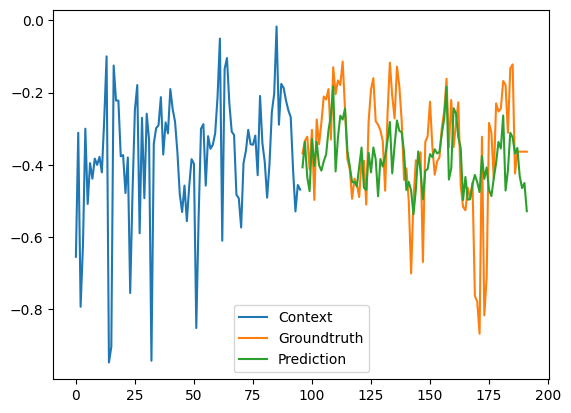

In [17]:
print(contexts.shape, preds.shape, trues.shape)
lookback = contexts.shape[1]
pred_len = preds.shape[1]
ind, ind_2 = rd.randint(0, preds.shape[0]-1), rd.randint(0, preds.shape[2]-1)
print(f"Plotting result for variable {ind_2} of series number {ind}")

plt.plot([i for i in range(lookback)], contexts[ind,:,ind_2], label='Context')
plt.plot([i for i in range(lookback, lookback+pred_len)], trues[ind,:,ind_2], label='Groundtruth')
plt.plot([i for i in range(lookback, lookback+pred_len)], preds[ind,:,ind_2], label='Prediction')
plt.legend()